FACET is composed of the following key components:

* **sklearndf**:  

    An augmented version of scikit-learn with enhanced support for pandas dataframes and pipelining.


* **Enhanced machine learning workflow**:

    FACET delivers a robust and fail-safe pipelining workflow which allows you to easily impute and select your features as well as ranking a grid of different models "competing" against each other


* **Model Inspection**:

    Local explanations of features and their interactions make up a key component of understanding feature importance as well as feature interactions. This is based on a novel method which decomposes SHAP values into three vectors representing synergy, redundancy, and independence.


* **Model Simulation**:

    Use your trained model and the insights from the model inspection to conduct a historical simulation of any feature on your target in order to identify local optima.

In [1]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

def _set_paths() -> None:
    # set the correct path when launched from within PyCharm

    module_paths = ["pytools", "facet", "sklearndf"]

    import sys
    import os
    
    if 'cwd' not in globals():
        # noinspection PyGlobalUndefined
        global cwd
        cwd = os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir)
        os.chdir(cwd)   
    print(f"working dir is '{os.getcwd()}'")
    for module_path in module_paths:
        if module_path not in sys.path:
            sys.path.insert(0, os.path.abspath(f"{cwd}/{os.pardir}/{module_path}/src"))
        print(f"added `{sys.path[0]}` to python paths")
        
def _ignore_warnings():
    # ignore irrelevant warnings that would affect the output of this tutorial notebook
    
    # ignore a useless LGBM warning
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, message=r".*Xcode_8\.3\.3")

_set_paths()
_ignore_warnings()

del _set_paths, _ignore_warnings

working dir is 'C:\Projects\facet\facet'
added `C:\Projects\facet\pytools\src` to python paths
added `C:\Projects\facet\facet\src` to python paths
added `C:\Projects\facet\sklearndf\src` to python paths


In [8]:
# this cell's metadata contains
# "nbsphinx": "hidden" so it is hidden by nbsphinx

import warnings
warnings.filterwarnings('ignore')

def _configure_matplotlib():
    # set global options for matplotlib
    
    import matplotlib
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
    matplotlib.rcParams['figure.dpi'] = 72

_configure_matplotlib()

del _configure_matplotlib

# Pipelining & Model Ranking

In [14]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearndf.pipeline import RegressorPipelineDF
from sklearndf.regression import RandomForestRegressorDF

# Relevant facet imports
from facet import Sample
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV

# Load boston housing dataset
boston = load_boston()
TARGET = 'MEDIAN_HOUSE_PRICE'
df = pd.DataFrame(
    data=boston.data,
    columns=boston.feature_names).assign(MEDIAN_HOUSE_PRICE=boston.target)
sample = Sample(observations=df, target=TARGET)


rf_pipeline = RegressorPipelineDF(
    regressor=RandomForestRegressorDF(random_state=42)
)

# Define grid of models which are "competing" against each other
grid = [
    LearnerGrid(
        pipeline=rf_pipeline,
        learner_parameters={"min_samples_leaf": [8, 11, 15]}
    )
]

# Create bootstrap CV iterator
cv = BootstrapCV(n_splits=10, random_state=42)

# Rank your models by performance
ranker = LearnerRanker(
    grids=grid,
    cv=cv,
    n_jobs=-3
).fit(sample=sample)

# Get your summary report
ranker.summary_report()

'Rank  1: RandomForestRegressorDF, ranking_score=    0.673, scores_mean=    0.793, scores_std=   0.0598, parameters={regressor__min_samples_leaf=8}\n\nRank  2: RandomForestRegressorDF, ranking_score=    0.666, scores_mean=    0.783, scores_std=   0.0589, parameters={regressor__min_samples_leaf=11}\n\nRank  3: RandomForestRegressorDF, ranking_score=    0.659, scores_mean=    0.771, scores_std=   0.0561, parameters={regressor__min_samples_leaf=15}\n'

# Easy model inspection

FACET implements a number of model inspection methods for scikit-learn base learners. Fundamentally, FACET enables post-hoc model inspection by breaking down the interaction effects of the variables that your model used for Training:

* ***Redundancy identifies groups of variables that fully or partially duplicate each other*** and do not deliver any additional information to the machine learning model.


* ***Synergy provides visibility about how features contain complementary information*** with respect to the target and team up to predict outcomes by combining their information.

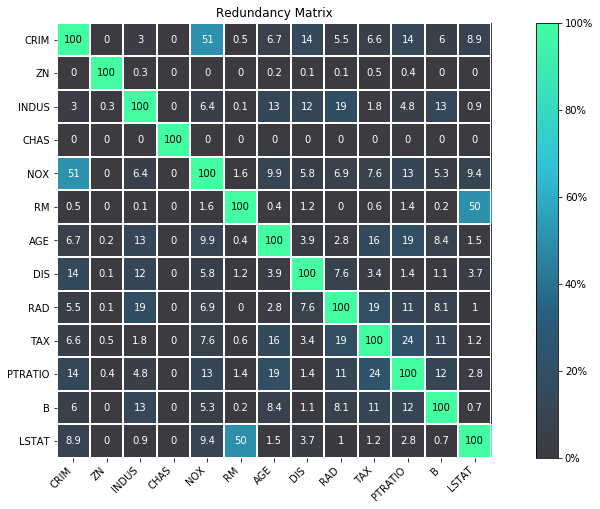

In [9]:
from facet.inspection import LearnerInspector
from pytools.viz.matrix import MatrixDrawer 

inspector = LearnerInspector()
inspector.fit(crossfit=ranker.best_model_crossfit)
MatrixDrawer(style="matplot%").draw(inspector.feature_redundancy_matrix(),
                                    title="Redundancy Matrix")

We can also better visualize redundancy as a dendrogram so we can identify clusters of features with redundancy.

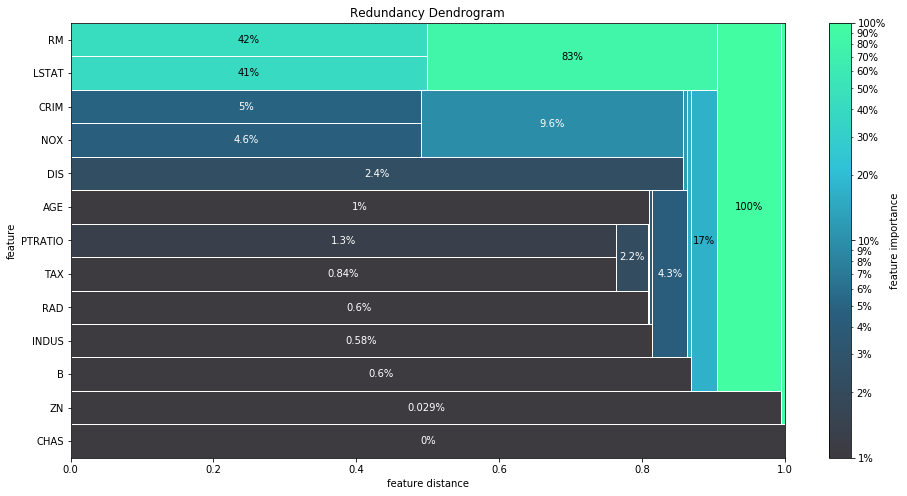

In [15]:
from pytools.viz.dendrogram import DendrogramDrawer

redundancy = inspector.feature_redundancy_linkage()
DendrogramDrawer().draw(data=redundancy, title='Redundancy Dendrogram')

For feature synergy, we can get a similar picture

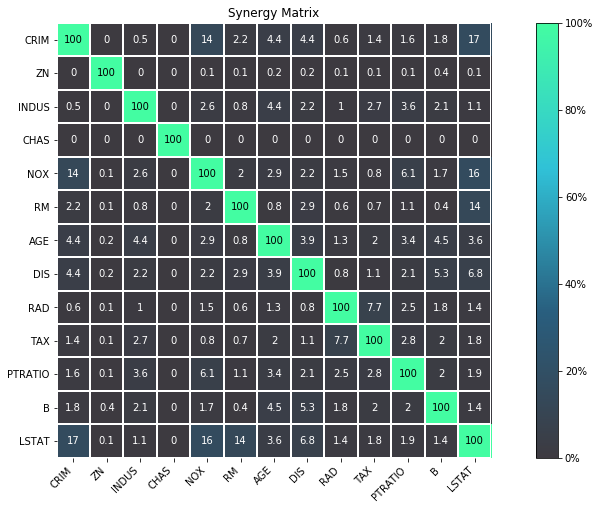

In [10]:
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

Please see the API documentation for more detail.

# Simulation

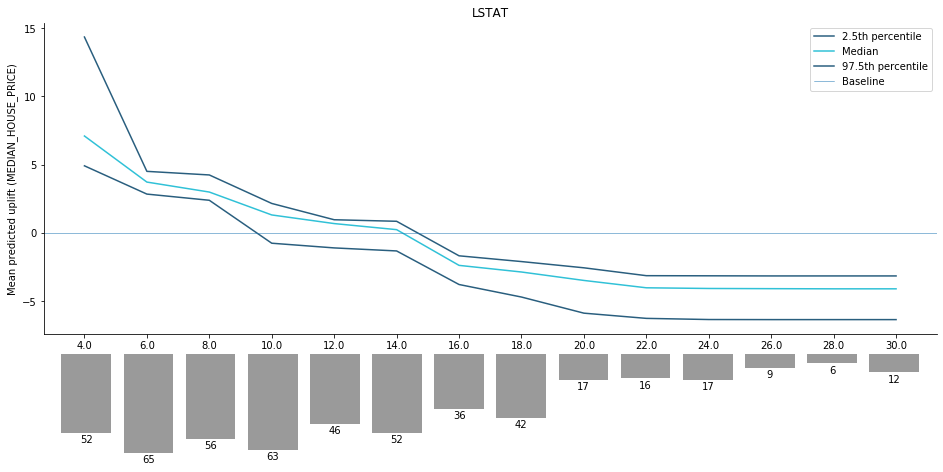

In [13]:
from facet.simulation import UnivariateUpliftSimulator
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation.viz import SimulationDrawer

SIM_FEAT = "LSTAT"
simulator = UnivariateUpliftSimulator(crossfit = ranker.best_model_crossfit, n_jobs=3)

# Split the simulation range into equal sized partitions
partitioner = ContinuousRangePartitioner()

simulation = simulator.simulate_feature(name=SIM_FEAT, partitioner = partitioner)

SimulationDrawer().draw(
    data=simulation, title=SIM_FEAT
)